# Run Aging Model

In [1]:
import pybamm # loads pybamm package
import matplotlib.pyplot as plt # package for plotting
import numpy as np # for arrays
import pandas as pd # for structure use .csv for importing and exporting
import math # log, sin, exp
from scipy.integrate import solve_ivp # integration, used in accelerated simulation
# from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter # for filtering in dVdQ
from scipy.signal import find_peaks # finding dVdQ peaks
from scipy import interpolate, integrate # for integrate
import os, sys # path stuff
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

import pickle # .mat
eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
cyc_DIR = "./data/cycling/"
fig_DIR = "./figures/"
res_DIR = "./results/"
resistance_DIR = "./data/resistance/"
%matplotlib widget

In [2]:
# loading parameter values without aging model parameters, just battery
parameter_values = get_parameter_values()
# we are defing the model
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

# Plot Capacity Loss (Fig 10)

## 100% DOD Cells

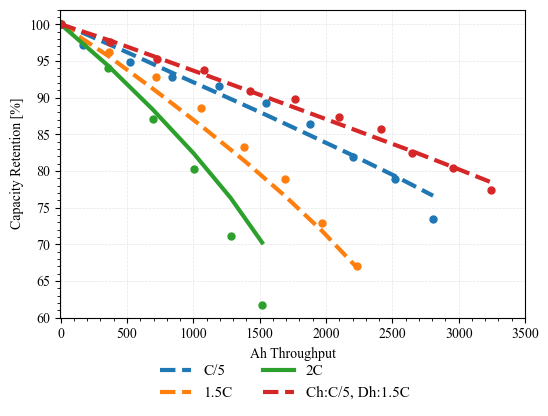

In [3]:
cells = [1,4,7,10]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+"cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    cap_data = dfe["Cap"]/dfe["Cap"][0]*100
    ax.plot(dfe["Ah_th"],cap_data,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    cap_sim = df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100
    if cell == 7:
        ax.plot(dfe["Ah_th"],cap_sim,color=colors[i],linewidth=3)
    else:    
        ax.plot(dfe["Ah_th"],cap_sim,'--',color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
ax.set_ylim([60,102])
ax.set_xlim([-5,3500])
fig.legend(['C/5','1.5C','2C','Ch:C/5, Dh:1.5C'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_cap_1.png')
plt.savefig(fig_DIR +'cycling_aging_room_cap_1'+'.png')
plt.show()

## 50% DOD Cells

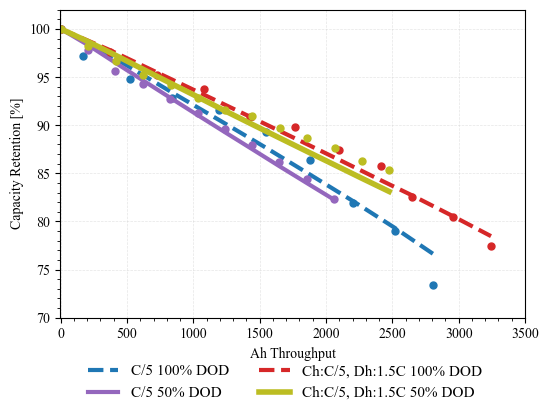

In [4]:
cells = [1,13,10,16]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim'+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    cap_data = dfe["Cap"]/dfe["Cap"][0]*100
    cap_sim = df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100
    if cell == 13:
        ax.plot(dfe["Ah_th"],cap_sim,color=colors[i],linewidth=3)
    elif cell == 16:
        ax.plot(dfe["Ah_th"],cap_sim,color=colors[i],linewidth=4)
    else:
        ax.plot(dfe["Ah_th"],cap_sim,'--',color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
# ax.set_title(r'C/20 Capacity')
ax.set_ylim([70,102])
ax.set_xlim([-5,3500])
fig.legend(['C/5 100% DOD','C/5 50% DOD','Ch:C/5, Dh:1.5C 100% DOD','Ch:C/5, Dh:1.5C 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_cap_2'+'.png')
plt.show()

# Plot Resistance Growth (Fig 12)

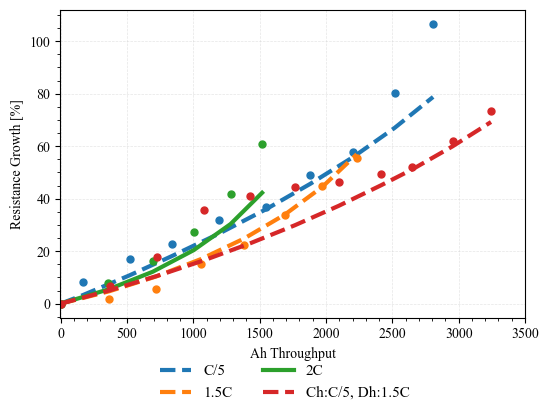

In [5]:
cells = [1,4,7,10]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    # df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    df = pd.read_csv(res_DIR + "DC_resistance"+"_cell_"+cell_no+".csv")
    
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    else:
        ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,'--',color=colors[i],linewidth=3)
    i+=1
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
fig.legend(['C/5','1.5C','2C','Ch:C/5, Dh:1.5C'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_resistance_1.png')
plt.savefig(fig_DIR +'cycling_aging_room_resistance_1'+'.png')

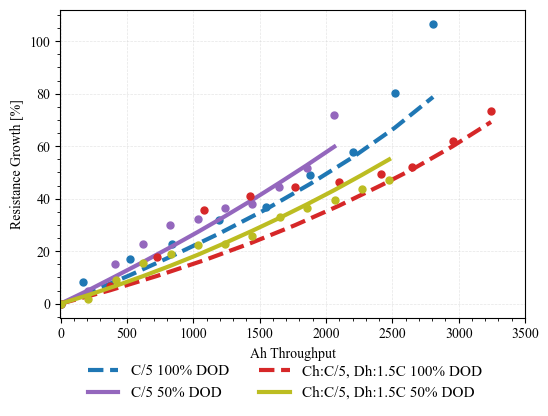

In [6]:
cells = [1,13,10,16]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13 or cell == 16:
        ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    else:
        ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,'--',color=colors[i],linewidth=3)
    i+=1
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
# ax.set_title(r'Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5 100% DOD','C/5 50% DOD','Ch:C/5, Dh:1.5C 100% DOD','Ch:C/5, Dh:1.5C 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_resistance_2.png')
plt.savefig(fig_DIR +'cycling_aging_room_resistance_2'+'.png')

# Plot Expansion (Fig 14)

In [7]:
b1 =544.61
b2 =11004.28
b3 =413.85
b4 =0.0

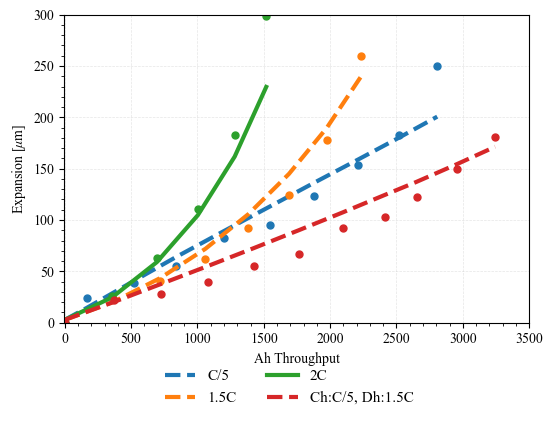

In [8]:
cells = [1,4,7,10]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim'+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    # del_sei = df["X-averaged SEI thickness [m]"]
    # del_li = df["X-averaged lithium plating thickness [m]"]
    # irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
    es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    else:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],'--',color=colors[i],linewidth=3)

    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
# ax.set_title(r'Irreversible Expansion')
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Ch:C/5, Dh:1.5C'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_expansion_1.png')
plt.savefig(fig_DIR +'cycling_aging_room_expansion_1'+'.png')
plt.show()

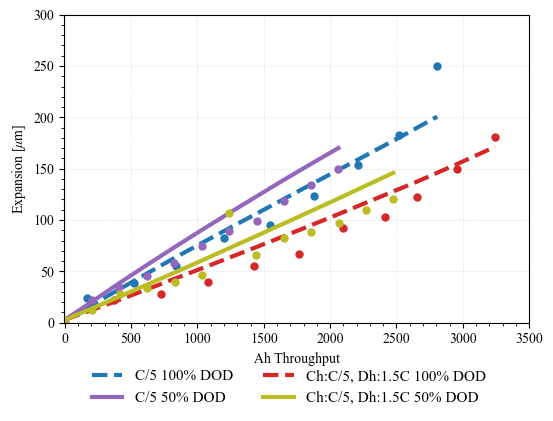

In [9]:
cells = [1,13,10,16]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim'+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    # del_sei = df["X-averaged SEI thickness [m]"]
    # del_li = df["X-averaged lithium plating thickness [m]"]
    # irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
    es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13 or cell == 16:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    else:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],'--',color=colors[i],linewidth=3)
    i+=1
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
fig.legend(['C/5 100% DOD','C/5 50% DOD','Ch:C/5, Dh:1.5C 100% DOD','Ch:C/5, Dh:1.5C 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion_2.png')
plt.show()

# Plot Degradation Modes (Fig 11)

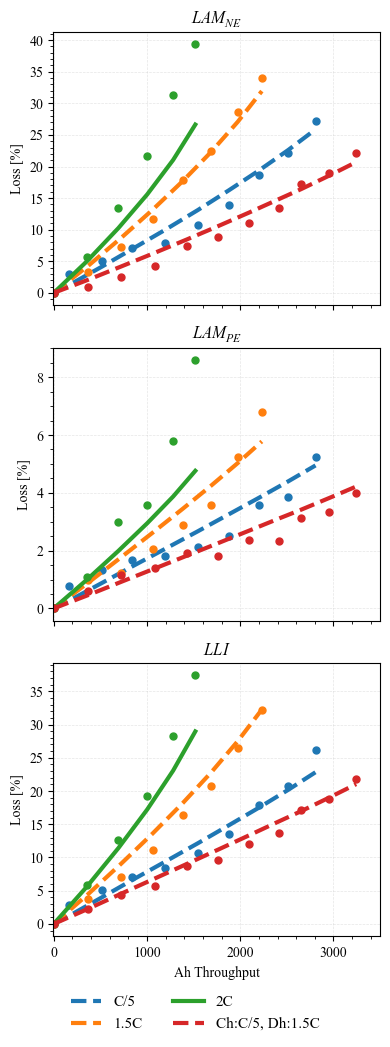

In [10]:
cells = [1,4,7,10]
fig, ax = plt.subplots(3,1,figsize=(4,10),sharex=True)
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim'+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax1 = ax.flat[0]
    ax1.plot(dfe["Ah_th"],(dfe["C_n"][0]-dfe["C_n"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax1.plot(dfe["Ah_th"],(df["C_n"][0]-df["C_n"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    else:
        ax1.plot(dfe["Ah_th"],(df["C_n"][0]-df["C_n"][Ns])/df["C_n"][0]*100,'--',color=colors[i],linewidth=3)
    ax2 = ax.flat[1]
    ax2.plot(dfe["Ah_th"],(dfe["C_p"][0]-dfe["C_p"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax2.plot(dfe["Ah_th"],(df["C_p"][0]-df["C_p"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    else:
        ax2.plot(dfe["Ah_th"],(df["C_p"][0]-df["C_p"][Ns])/df["C_n"][0]*100,'--',color=colors[i],linewidth=3)
    ax3 = ax.flat[2]
    ax3.plot(dfe["Ah_th"],dfe["Loss of lithium inventory [%]"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax3.plot(dfe["Ah_th"],df["Loss of lithium inventory [%]"][Ns],color=colors[i],linewidth=3)
    else:
        ax3.plot(dfe["Ah_th"],df["Loss of lithium inventory [%]"][Ns],'--',color=colors[i],linewidth=3)
    i+=1
ax3.set_xlabel('Ah Throughput')
ax1.set_ylabel(r"Loss [%]")
ax2.set_ylabel(r"Loss [%]")
ax3.set_ylabel(r"Loss [%]")
ax1.set_title(r'$LAM_{NE}$')
ax2.set_title(r'$LAM_{PE}$')
ax3.set_title(r'$LLI$')
# ax.set_ylim([60,102])
ax1.set_xlim([-5,3500])
fig.legend(['C/5','1.5C','2C','Ch:C/5, Dh:1.5C'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=2, fontsize=11)
fig.tight_layout()
plt.savefig(fig_DIR +'cycling_aging_room_deg_mode_1.png')
plt.show()

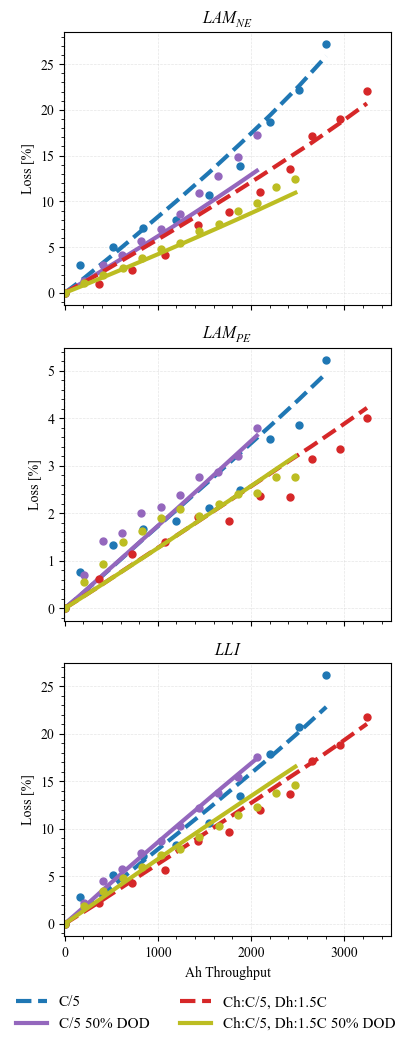

In [11]:
cells = [1,13,10,16]
fig, ax = plt.subplots(3,1,figsize=(4,10),sharex=True)
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim'+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax1 = ax.flat[0]
    ax1.plot(dfe["Ah_th"],(dfe["C_n"][0]-dfe["C_n"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13 or cell == 16:
        ax1.plot(dfe["Ah_th"],(df["C_n"][0]-df["C_n"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    else:
        ax1.plot(dfe["Ah_th"],(df["C_n"][0]-df["C_n"][Ns])/df["C_n"][0]*100,'--',color=colors[i],linewidth=3)
    ax2 = ax.flat[1]
    ax2.plot(dfe["Ah_th"],(dfe["C_p"][0]-dfe["C_p"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13 or cell == 16:
        ax2.plot(dfe["Ah_th"],(df["C_p"][0]-df["C_p"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    else:
        ax2.plot(dfe["Ah_th"],(df["C_p"][0]-df["C_p"][Ns])/df["C_n"][0]*100,'--',color=colors[i],linewidth=3)
    ax3 = ax.flat[2]
    ax3.plot(dfe["Ah_th"],dfe["Loss of lithium inventory [%]"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13 or cell == 16:
        ax3.plot(dfe["Ah_th"],df["Loss of lithium inventory [%]"][Ns],color=colors[i],linewidth=3)
    else:
        ax3.plot(dfe["Ah_th"],df["Loss of lithium inventory [%]"][Ns],'--',color=colors[i],linewidth=3)
    i+=1
ax3.set_xlabel('Ah Throughput')
ax1.set_ylabel(r"Loss [%]")
ax2.set_ylabel(r"Loss [%]")
ax3.set_ylabel(r"Loss [%]")
ax1.set_title(r'$LAM_{NE}$')
ax2.set_title(r'$LAM_{PE}$')
ax3.set_title(r'$LLI$')
ax1.set_xlim([-5,3500])
fig.legend(['C/5','C/5 50% DOD','Ch:C/5, Dh:1.5C','Ch:C/5, Dh:1.5C 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=2, fontsize=11)
fig.tight_layout()
plt.savefig(fig_DIR +'cycling_aging_room_deg_mode_2.png')
plt.show()

# Plot Voltage, Expansion and Current at BOL,MOL and EOL (Fig 15)

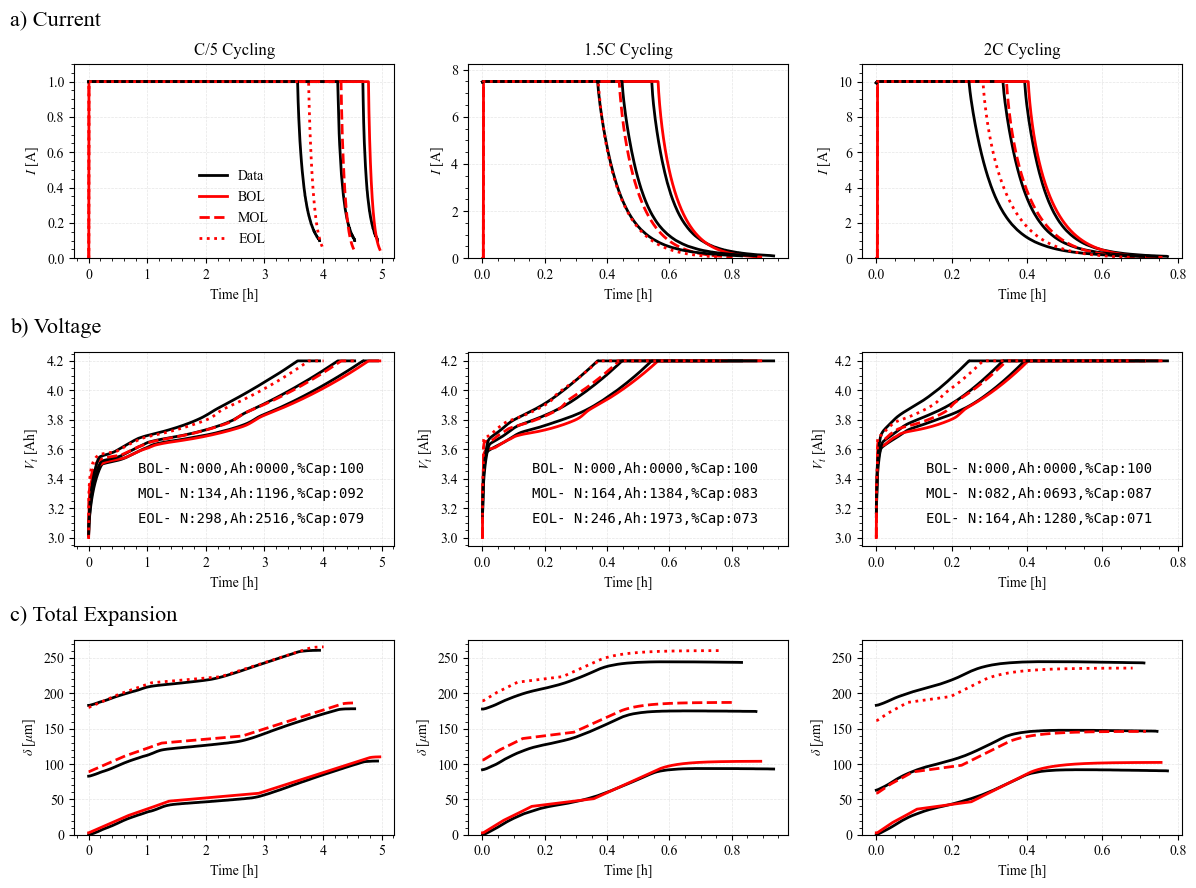

In [12]:
titles = ["BOL","MOL","EOL"]
linestyles = ["solid","dashed","dotted"]
i = 0
fig, ax = plt.subplots(3,3,figsize=(12,9))
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
with open(res_DIR+'fast_sim'+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    df = pickle.load(handle)
del_sei = df["X-averaged SEI thickness [m]"]
del_li = df["X-averaged lithium plating thickness [m]"]
irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
cycles = [0,int((len(N)+1)/2),len(N)-2]
if cell == 1:
    cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
cyc_no = cycles[0]
ax2 = ax.flat[0]
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
df = pd.read_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
ax2.plot(t_d/3600,I_d,'k',linewidth=2)
ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[0])
ax2.set_xlabel('Time [h]')
ax2.set_ylim(bottom=0)
ax2.set_ylabel('$I$ [A]')
cyc_no = cycles[1]
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
df = pd.read_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
ax2.plot(t_d/3600,I_d,'k',linewidth=2,label="_nolegend_")
ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[1])
cyc_no = cycles[2]
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
df = pd.read_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
ax2.plot(t_d/3600,I_d,'k',linewidth=2,label="_nolegend_")
ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[2])
ax2.legend(["Data","BOL","MOL","EOL"])
cells = [1,4,7]
for cell in cells:
    j=0
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim'+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    # del_sei = df["X-averaged SEI thickness [m]"]
    # del_li = df["X-averaged lithium plating thickness [m]"]
    # irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
    es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
    cycles = [0,int((len(N)+1)/2),len(N)-2]
    if cell == 1:
        cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
    if cell == 7:
        cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
    for cyc_no in cycles:
        t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
        df = pd.read_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
        rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
        ax1 = ax.flat[i+3]
        ax1.plot(t_d/3600,V_d,'k',linewidth=2)
        ax1.plot(df['t']/3600,df["Vt"],'r',linewidth=2,linestyle=linestyles[j])
        ax1.set_xlabel('Time [h]')
        ax1.text(0.2,0.38-0.13*j,'{}- N:{:03.0f},Ah:{:04.0f},%Cap:{:03.0f}'.format(titles[j],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100),transform=ax1.transAxes,family='monospace',fontsize='10')
        ax1.set_ylabel('$V_t$ [Ah]')
        if cell == 1:
            pass
        else:
            ax2 = ax.flat[i]
            ax2.plot(t_d/3600,I_d,'k',linewidth=2)
            ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[j])
            ax2.set_xlabel('Time [h]')
            ax2.set_ylim(bottom=0)
            ax2.set_ylabel('$I$ [A]')
        # ax2.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
        ax3 = ax.flat[i+6]
        ax3.plot(t_d/3600,E_d+dfe["irrev_exp"][cyc_no],'k',linewidth=2)
        ax3.plot(df['t']/3600,df["Exp"]+irrev_exp[Ns[cyc_no]],'r',linewidth=2,linestyle=linestyles[j])
        ax3.set_xlabel('Time [h]')
        ax3.set_ylim([0,275])
        ax3.set_ylabel('$\delta$ [$\mu$m]')
        # ax3.text(0.5,0.2,f'RMSE: {rmse_E:0.1f}'+ r'$\mu$m',transform=ax3.transAxes)
        j+=1
    i+=1
ax10 = ax.flat[0]
ax10.text(-0.2,1.2,f'a) Current',transform=ax10.transAxes,fontsize=16)
ax10.set_title("C/5 Cycling")
ax11 = ax.flat[1]
ax11.set_title("1.5C Cycling")
ax12 = ax.flat[2]
ax12.set_title("2C Cycling")
ax20 = ax.flat[3]
ax20.text(-0.2,1.1,f'b) Voltage',transform=ax20.transAxes,fontsize=16)
ax30 = ax.flat[6]
ax30.text(-0.2,1.1,f'c) Total Expansion',transform=ax30.transAxes,fontsize=16)
# ax3.legend(["Data","Sim"])
fig.tight_layout()
plt.savefig(fig_DIR +'volt_exp_error_cell_all_ch.png')

# Plot Resistance vs SOC (Fig 13)

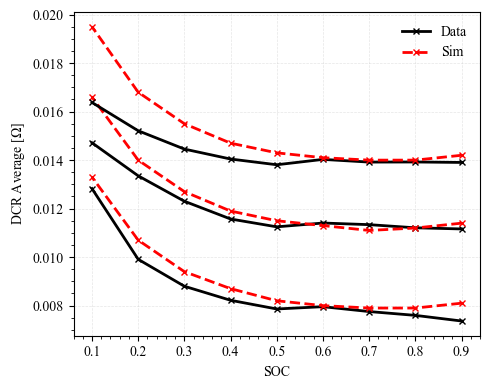

In [13]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
soc = np.linspace(0.9,0.1,9)
res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
res_sim = pd.read_csv(res_DIR + "DC_resistance"+"_cell_"+cell_no+".csv")

titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,1,figsize=(5,4))
i = 0
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
    res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
    res_sim = pd.read_csv(res_DIR + "DC_resistance"+"_cell_"+cell_no+".csv")
    res_array = res_sim.Rs_s[cyc_no].replace('[',"")
    res_array = res_array.replace(']',"")
    res_array = np.fromstring(res_array,sep=" ")
    res_data[res_data == 0] = 'nan'
    ax1 = ax
    ax1.plot(soc,res_data[cyc_no],'kx-')
    ax1.plot(soc,res_array,'rx--')
    ax1.set_xlabel('SOC')
    ax1.set_ylabel(r'DCR Average [$\Omega$]')
    # ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    i+=1
ax1.legend(["Data","Sim"])
# fig.suptitle('DCR Ave vs SOC')
fig.tight_layout()
# ax.legend(['Data','Sim'])
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
plt.savefig(fig_DIR +'resistance_SOC_cell_'+cell_no+'_all.png')